## Imports

In [1]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm

except Exception as e:
    print(f"Some module are missing: {e}\n")

data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models", "best_100_campioni_new.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

plt.style.use('seaborn-v0_8-paper')


Some module are missing for /home/cnr-ismn-2/Scrivania/Mario/Phd_code/GDD/GrapheNetDefectDetector/lib/lib_defect_analysis.py: No module named 'skimage'



## Generate images from xyz files

In [2]:
Utils.from_xyz_to_png(xyz_files_path, images_path)

## YOLO inference to generate binary crops

In [2]:
Utils.generate_yolo_crops(
    images_path,
    crops_path,
    yolo_model_path,
    binary_mask=True,
)

## Features extraction and dataframe generation

In [3]:
images = [
    f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
]

features = {}

for image in tqdm(images):
    if len(features) == 0:
        keys_list = list(features.keys())
        df = pd.DataFrame(columns=keys_list)
    else:
        features.clear()

    name = image.stem.split("_crop")[0]

    with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
        first_line = file.readline()
    n_atoms = int(first_line.strip())

    features.update({"file_name": name})
    features.update({"n_atoms": n_atoms})

    shape_features = Features.extract_shape_features(image, grayscale=True)
    if shape_features is not None:
        features.update(shape_features)

    edge_features = Features.extract_edge_features(image, grayscale=True)
    if edge_features is not None:
        features.update(edge_features)

    new_row = pd.Series(features)
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

grouped_df = (
    df.groupby("file_name")
    .agg(
        {
            "n_atoms": "first",
            "area": "sum",
            "num_pixels": "sum",
            "perimeter": "sum",
            "circularity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "solidity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "compactness": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "number_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            # "mean_length_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
            # "std_length_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        }
    )
    .reset_index()
)


original_df = pd.read_csv(xyz_files_path.joinpath("dataset_graphene.csv"))

energy_dict = original_df.set_index("file_name")["total_energy"].to_dict()

# Aggiunta della colonna total_energy al primo dataframe
grouped_df["total_energy"] = grouped_df["file_name"].map(energy_dict)
grouped_df["energy_per_atom"] = grouped_df["total_energy"] / grouped_df["n_atoms"]

grouped_df.to_csv(data_path.joinpath("features.csv"), index=False)

  0%|          | 0/7037 [00:00<?, ?it/s]

100%|██████████| 7037/7037 [00:04<00:00, 1488.54it/s]


## Plot correlations

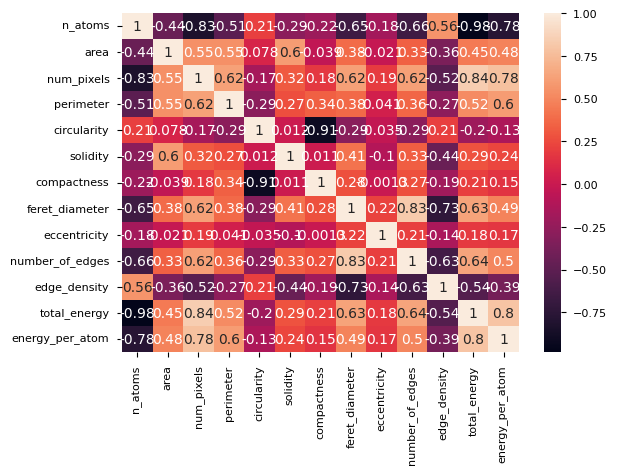

In [4]:
grouped_df = pd.read_csv(data_path.joinpath("features.csv"))
grouped_df = grouped_df.drop(grouped_df[grouped_df["total_energy"] > -2500].index)

columns_to_drop = ["file_name"]
merged_df = grouped_df.drop(columns_to_drop, axis=1)

# stampo heatmap
corr = merged_df.corr(method="kendall")
target_correlation = corr[["total_energy", "energy_per_atom"]]

sns.heatmap(corr, annot=True)

# stampo basic correlogram
# sns.pairplot(merged_df)
plt.show()

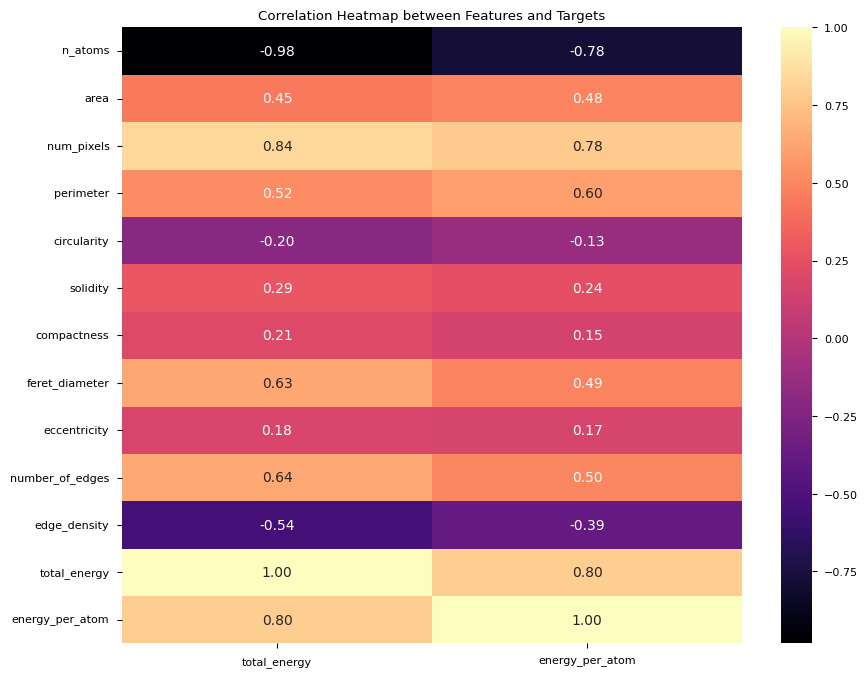

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Heatmap between Features and Targets")
plt.show()

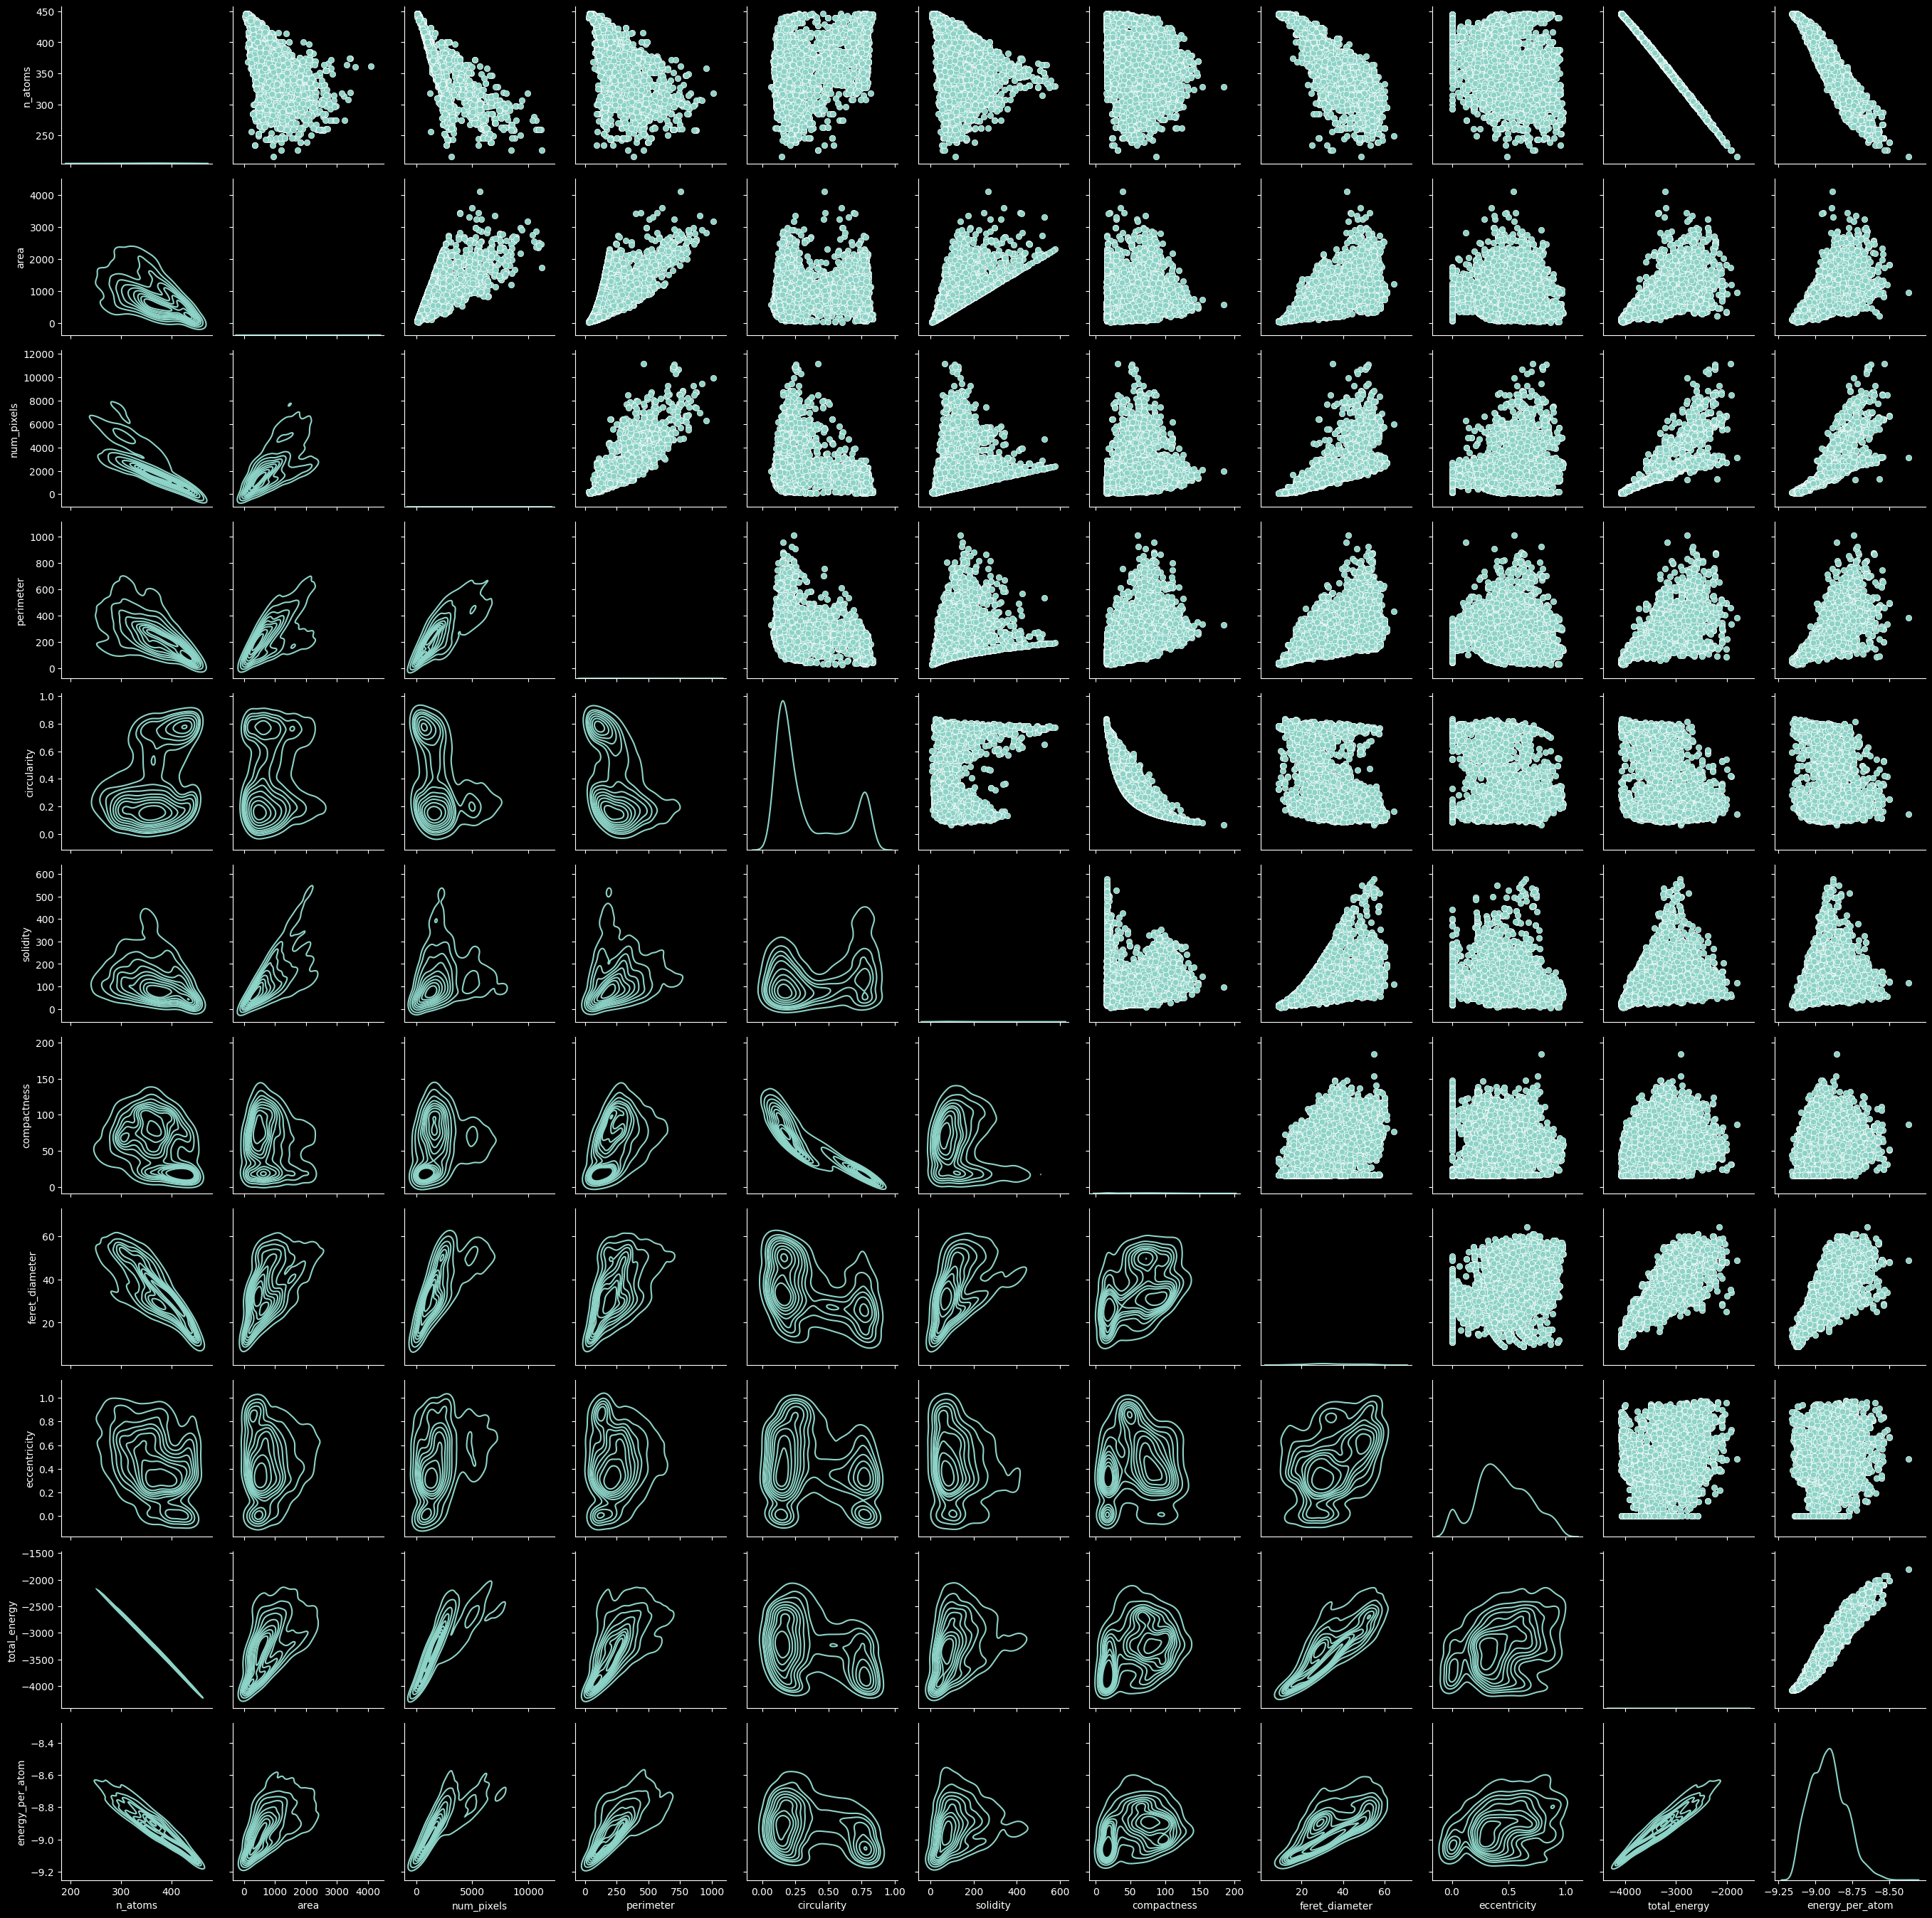

In [6]:
g = sns.PairGrid(grouped_df)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)

## Total energy prediction

In [7]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy

except Exception as e:
    print(f"Some module are missing: {e}\n")

## Data preparation

In [17]:
# features_list = [ "area","perimeter", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity", "number_of_edges", "edge_density", "mean_length_of_edges", "std_length_of_edges"]
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "compactness",
    "feret_diameter",
    "eccentricity",
    "number_of_edges",
    "edge_density",
]

X = grouped_df[features_list].values

y = grouped_df[
    "total_energy"
].values.flatten()  # array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))

## Split dataset and set hyperparameters

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_norm, test_size=0.1, random_state=13
)

XGBOOST senza k-fold


In [22]:
import xgboost as xgb
# Selezione delle quattro feature con maggiore importanza
# +++++++++++ TOTAL ENERGY+++++++++++++++
# params = {
#     "n_estimators": 1500,
#     "min_samples_split": 5,
#     "learning_rate": 0.1,
#     #"loss": "absolute_error",
# }
# +++++++++++ TOTAL ENERGY+++++++++++++++


# params = {"learning_rate": 0.06527271184152461,
#           "n_estimators":830,
#     "max_depth": 6,
#     "min_samples_split": 9,
#     "min_samples_leaf": 10}
# params = {
#     "n_estimators": 1479,
#     "learning_rate": 0.05664451707023027,
#     "max_depth": 7,
#     "gamma" : 3,
#     "min_child_weight":1.3,
#     "colsample_bytree":0.89,
#     "subsample":0.8
#     "min_samples_split": 11,
#     "min_samples_leaf": 10,
# }
# params = {'n_estimators': 1628, 'learning_rate': 0.03843617646475424, 'max_depth': 6}
# +++++++++++  ENERGY PER ATOM +++++++++++++++
params = {
    "n_estimators": 1850,
    "learning_rate": 0.025250129884021043,
    "max_depth": 9,
    "gamma": 0.000731247172308212,
    "min_child_weight": 8.408269160115502,
    "colsample_bytree": 0.9702313623914688,
    "subsample": 0.5094062459445882,
}
# #model = ensemble.GradientBoostingRegressor(**params)
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)

/home/cnr-ismn-2/anaconda3/envs/yolo_gdd/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:39:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcola l'errore quadratico medio
mse = mean_squared_error(y_test, y_pred)

# Calcola l'errore assoluto medio
mae = mean_absolute_error(y_test, y_pred)

# Calcola il coefficiente di determinazione (R-squared)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Mean Squared Error (MSE): 0.003438264629121036
Mean Absolute Error (MAE): 0.03674782905647395
R-squared: 0.9509294077374482


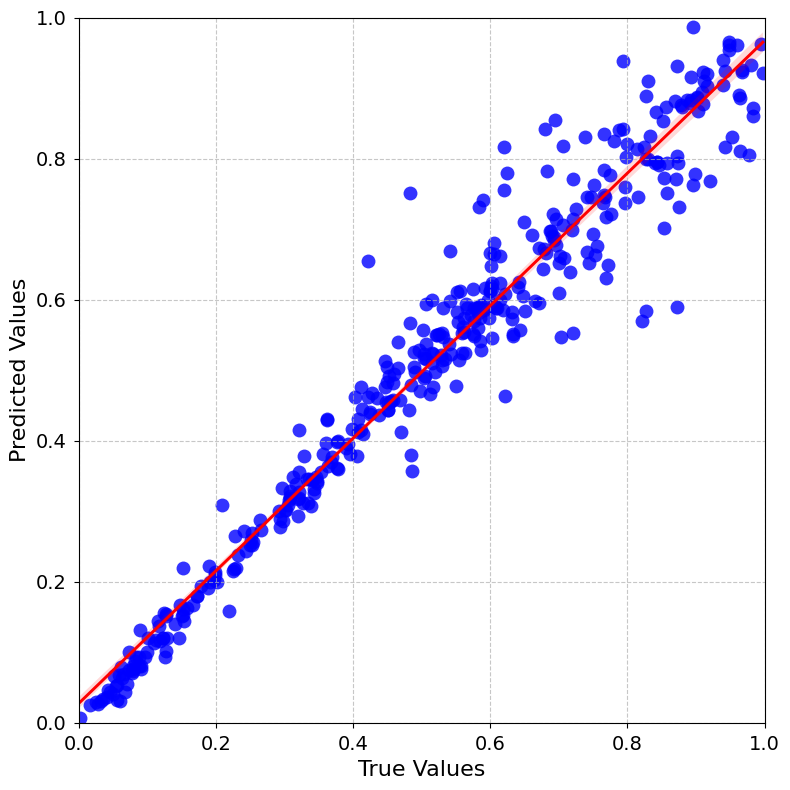

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 8))
sns.regplot(x=np.ravel(y_test), y=np.ravel(y_pred), scatter_kws={'s': 100}, color='b', marker='o', line_kws={"color": "red"})
plt.ylabel('Predicted Values', fontsize=16)
plt.xlabel('True Values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./scatter.png", dpi=300)
plt.show()


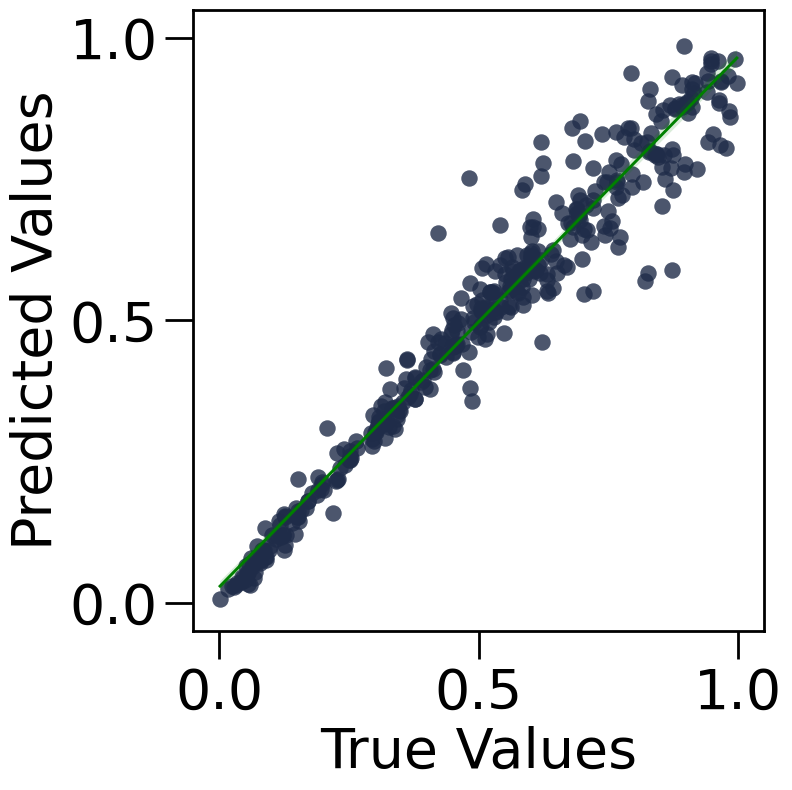

In [46]:

plt.figure(figsize=(8,8))
sns.regplot(x=np.ravel(y_test), y=np.ravel(y_pred), scatter_kws={'s': 140}, color=[31/255,44/255,73/255],line_kws={"color": "green"})
plt.ylabel('Predicted Values',fontsize=40)
plt.xlabel('True Values',fontsize=40)
plt.yticks([0,0.5,1.0],fontsize=40)
plt.xticks([0.0,0.5,1.0],fontsize=40)
#plt.legend(fontsize=20)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.tick_params(axis='both', which='major', length=20, width=2)  # Adjust tick size

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.savefig("./scatter.png", dpi=300)

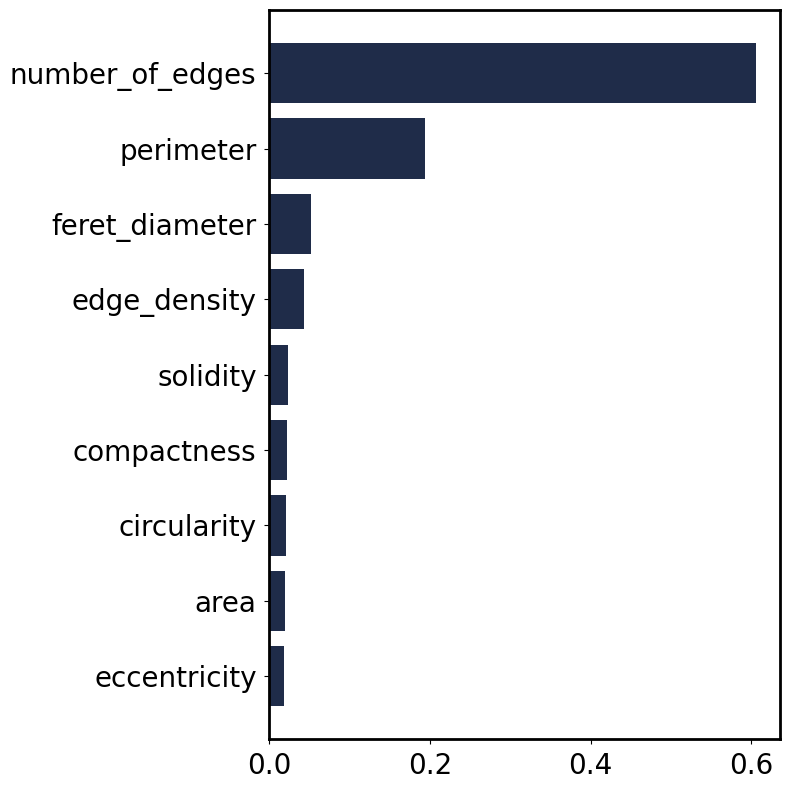

In [50]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center", color=[31/255,44/255,73/255])
plt.yticks(pos, np.array(features_list)[sorted_idx], fontsize=20)
plt.xticks([0,0.2,0.4,0.6],fontsize=20)
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
# plt.boxplot(
#     result.importances[sorted_idx].T,
#     vert=False,
#     labels=np.array(features_list)[sorted_idx],
# )
#plt.title("Permutation Importance (test set)")

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
fig.tight_layout()
plt.savefig("features_imp")
plt.show()

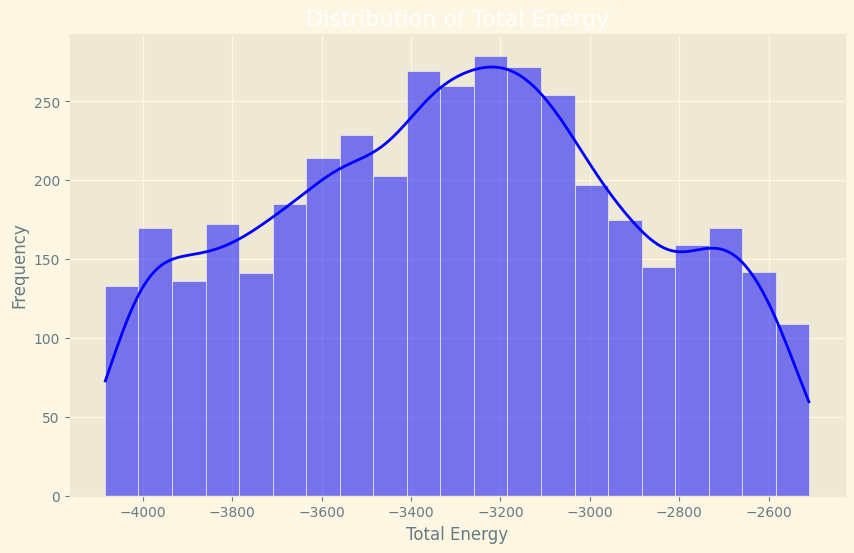

In [271]:
# Plot della distribuzione della variabile target total_energy
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color="blue")
plt.xlabel("Total Energy")
plt.ylabel("Frequency")
plt.title("Distribution of Total Energy")
plt.show()

## Set regressor and loss function

## TEST K FOLD
qui con k fold implementato


MEAN R2 scores 0.9103981623266753 with Gradient Boost: 


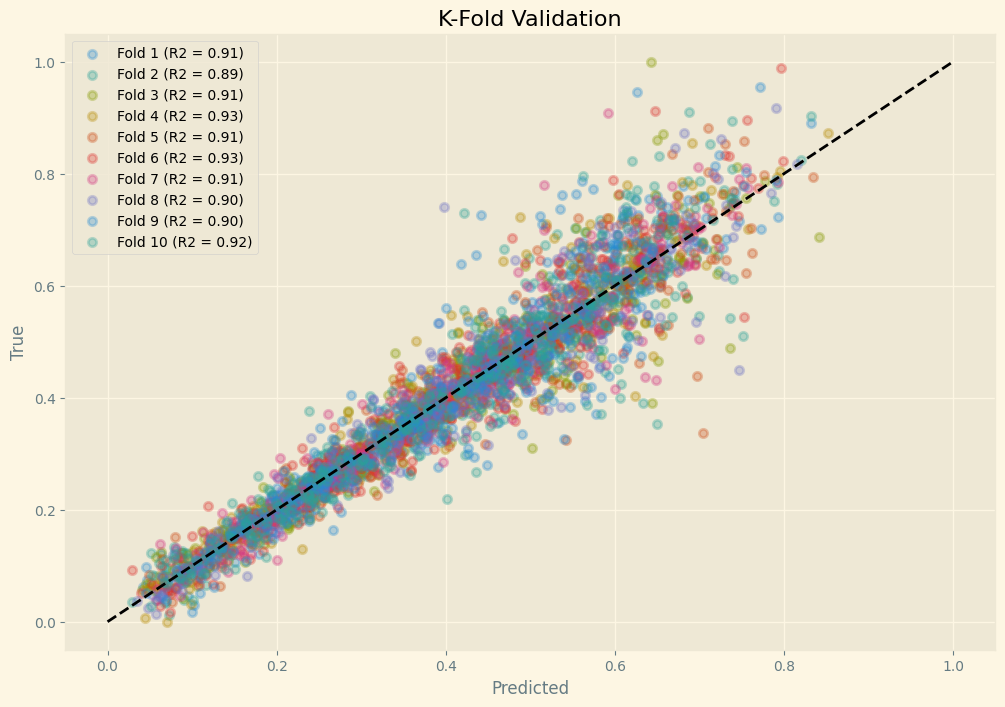

In [328]:
from sklearn import model_selection, metrics
from statistics import mean
import xgboost as xgb
import matplotlib.pyplot as plt

# Definizione dei parametri e inizializzazione del modello
params = {
    "n_estimators": 1850,
    "learning_rate": 0.025250129884021043,
    "max_depth": 9,
    "gamma": 0.000731247172308212,
    "min_child_weight": 8.408269160115502,
    "colsample_bytree": 0.9702313623914688,
    "subsample": 0.5094062459445882,
}

model_boost = xgb.XGBRegressor(**params)

# Preparazione dei dati
y_train = y_train.ravel()
cv = model_selection.KFold(n_splits=10, random_state=1, shuffle=True)

# Creazione della figura e dell'asse
fig, ax = plt.subplots(figsize=(12, 8))

# Ciclo sui fold di cross-validation
scores = []
for i, (train, test) in enumerate(cv.split(X_train, y_train), start=1):
    prediction = model_boost.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    ax.scatter(
        prediction, true, lw=2, alpha=0.3, label="Fold %d (R2 = %0.2f)" % (i, score)
    )

# Tracciamento della linea di riferimento
ax.plot(
    [min(y_train), max(y_train)],
    [min(y_train), max(y_train)],
    linestyle="--",
    lw=2,
    color="black",
)

# Calcolo e stampa della media dei punteggi R2
mean_r2 = mean(scores)
print("MEAN R2 scores {} with Gradient Boost: ".format(mean_r2))

# Impostazione degli elementi del grafico
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("K-Fold Validation", color="black")
ax.legend()

# Impostazione del colore del testo della legenda
for text in ax.get_legend().get_texts():
    text.set_color("black")

# Mostra il grafico
plt.show()

In [88]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train.ravel())

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0051


## Deviance

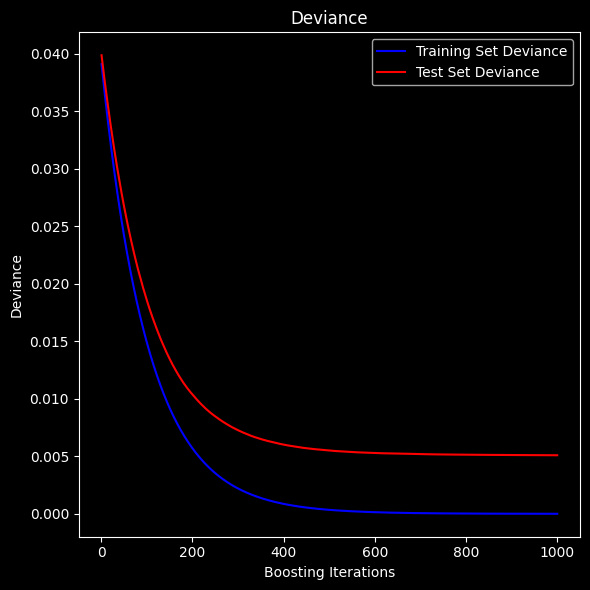

In [89]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Features importance

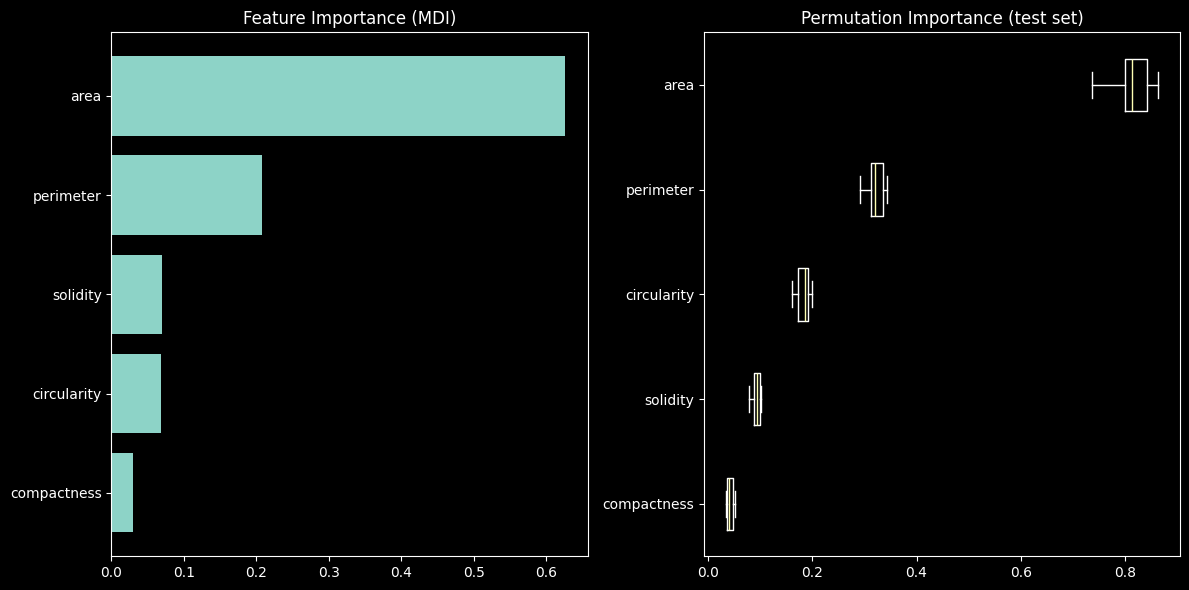

In [90]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Fit curve

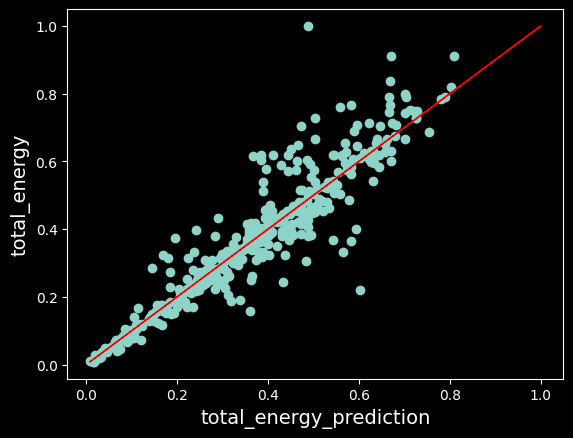

In [91]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color="red", linewidth=1)

plt.xlabel("total_energy_prediction", fontsize=14)
plt.ylabel("total_energy", fontsize=14)
plt.show()

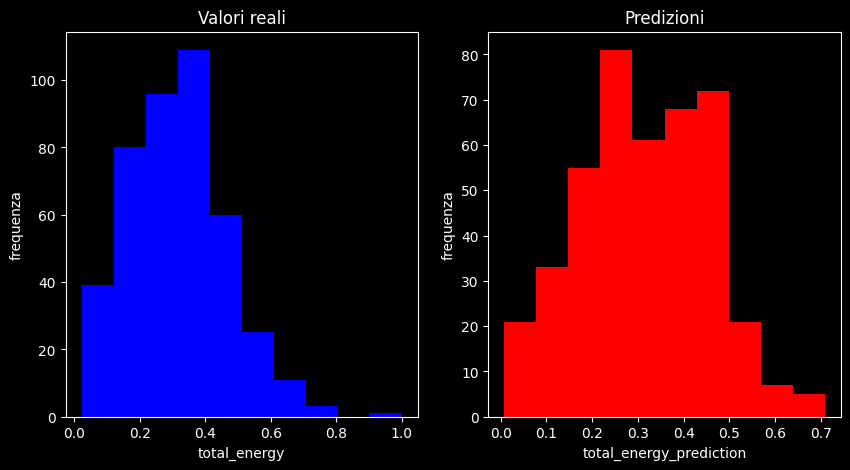

In [25]:
# Crea la figura e i due assi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Istogramma 1
# ax1.hist(y_test, bins=5, weights=y_test, color='blue')
ax1.hist(y_test, bins=10, color="blue")

ax1.set_xlabel("total_energy")
ax1.set_ylabel("frequenza")
ax1.set_title("Valori reali")

# Istogramma 2
# ax2.hist(y_pred, bins=5, weights=y_pred, color='red')
ax2.hist(y_pred, bins=10, color="red")
ax2.set_xlabel("total_energy_prediction")
ax2.set_ylabel("frequenza")
ax2.set_title("Predizioni")

# Mostra il grafico
plt.show()

In [26]:
res = scipy.stats.ttest_ind(y_test, y_pred, equal_var=True)

display(res)

TtestResult(statistic=array([   -0.41249,      1.8983,      1.6304,    -0.46002,     0.94355,     0.41028,    -0.43563,     0.90428,     0.86699,   -0.023533,     0.39206,      1.7278,      1.5144,       1.185,      0.5487,     -1.4501,   -0.044325,     -0.8935,      1.0154,    -0.44361,    -0.35368,    -0.83095,    -0.71441,     -1.0143,
            1.0501,      1.4457,     -0.1518,      1.7385,    -0.19599,     -1.5818,   -0.066501,    -0.35131,    -0.45561,      1.1697,     -1.0971,     0.62155,     -1.0675,      1.0854,     -1.0938,      1.0694,      1.4832,     -0.1021,    -0.65699,      1.0865,     0.98591,     0.92023,      1.1551,    -0.16179,
            0.8148,     0.38006,     0.35989,     -0.9992,     -1.0285,    -0.16585,     -1.2053,     -1.2021,    -0.67509,     -1.4194,     -1.1215,     -1.1577,     0.73081,     -0.8935,     -0.2965,    -0.17268,    -0.44646,     -1.1809,     0.69955,    -0.22159,    -0.71029,     0.20119,    0.090354,     -1.2072,
            1.2525,  

## Predictions - Real Target Values

In [27]:
print("Target total_energy: ")
print(y_test[1:10])
print("Predicted total_energy: ")
print(reg.predict(X_test[1:10]))
print("Error: ")
print(y_test[1:10] - reg.predict(X_test[1:10]))

Target total_energy: 
[[   0.067702]
 [   0.069273]
 [    0.36239]
 [    0.18276]
 [    0.26699]
 [    0.40405]
 [    0.17297]
 [    0.17248]
 [    0.27847]]
Predicted total_energy: 
[   0.033238    0.073214     0.38517     0.17572     0.25529     0.38153     0.18158     0.18714     0.32003]
Error: 
[[   0.034464  -0.0055116    -0.31746    -0.10801    -0.18759    -0.31382    -0.11387    -0.11944    -0.25233]
 [   0.036035  -0.0039412    -0.31589    -0.10644    -0.18602    -0.31225     -0.1123    -0.11787    -0.25076]
 [    0.32915     0.28918   -0.022774     0.18668      0.1071   -0.019134     0.18082     0.17525    0.042361]
 [    0.14952     0.10954    -0.20241   0.0070398   -0.072539    -0.19877   0.0011796  -0.0043844    -0.13728]
 [    0.23376     0.19378    -0.11817    0.091279    0.011701    -0.11453    0.085419    0.079855   -0.053036]
 [    0.37082     0.33084    0.018888     0.22834     0.14876    0.022528     0.22248     0.21691    0.084024]
 [    0.13973    0.099753     -0.

## R^2 Score

In [28]:
reg.score(X_test, y_test)

0.8196384477638423